# Chapter 6. RNN with Gate (LSTM, GRU 계층)

## 1. RNN의 문제점

앞 장에서 언급한 대로, RNN은 시퀀스가 길어질 경우, gradient vanishing (or gradient exploding) 문제가 발생한다.

- 원인 1 : RNN에서 계산되는 함수 $\tanh(x)$의 형태를 보자.

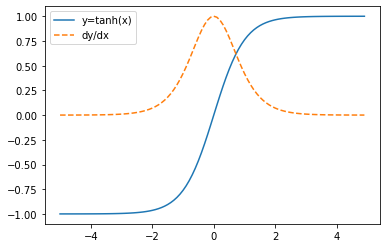

In [8]:
# tanh function illustration
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(-5,5,0.1)
y1 = np.tanh(x)
y2 = 1 - y1 ** 2
plt.plot(x,y1,label='y=tanh(x)')
plt.plot(x,y2,ls='--',label='dy/dx')
plt.legend()
plt.show()

    위와 같이, $\tanh(x)$는 0에서는 기울기가 1이지만, 0에서 멀어질수록 기울기가 0에 가까워지는 문제가 있다.
    -> 기울기가 역전파를 반복할수록 작아지는 문제 발생.
    NOTE : 이 문제의 경우 ReLU 함수를 써서 대체 가능.
- 원인 2 : RNN 계층의 시간에 따른 기울기 역전파에는 weight matrix $W_h$가 연속해서 곱해짐.<br>
    -> 시간축으로의 역전파가 반복될 수록 $W^2_h$, $W^3_h$, ... 식으로 연속해서 곱해지면, 0으로 수렴하거나, 무한대로 발산할 수 있음. 
    <br>
    https://arxiv.org/abs/1211.5063 참고
    

- Gradient exploding 문제 대책 : gradient clipping.
    - Gradient의 L2 norm이 *threshold*보다 커질 경우, gradient $g$를 다음과 같이 rescaling함.<br>
\begin{equation}
g_{new} = \frac{\textit{threshold}}{||g||}g .
\end{equation}

In [9]:
# Gradient clipping
# common/util.py 에 구현됨.

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm) # L2 norm
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
          
print(grads)
clip_grads(grads,max_norm)
print(grads)

[array([[3.37731592, 8.11998845, 7.96032326],
       [0.87341069, 9.56385317, 9.25867808],
       [6.48460757, 2.49734401, 5.56587231]]), array([[8.67305792, 8.93943951, 6.46754862],
       [1.76190047, 6.83608366, 8.01913903],
       [3.58488989, 7.74981107, 4.05756025]])]
[array([[0.5976254 , 1.43685443, 1.40860123],
       [0.15455244, 1.69235029, 1.63834871],
       [1.14746926, 0.44191193, 0.98489651]]), array([[1.5347216 , 1.58185856, 1.14445063],
       [0.31177316, 1.20966392, 1.41900885],
       [0.63435619, 1.37135052, 0.71799652]])]


## 2. Gradient Vanishing and LSTM

- Memory cell $c_t$ : 계층 내에서만 전파되는 추가 요소. 은닉상태 (hidden state)와는 다름.
    - 과거로부터 시간 $t$ 까지의 정보가 저장되어 있음.
    - $h_{t-1}$, $c_{t-1}$, $x_t$를 가지고 $c_t$가 결정됨.
    - 갱신된 $c_t$를 가지고 $h_t$가 계산됨. <br>
    $h_t = \tanh(c_t)$. 
- Gate : 이전 계층에서 다음 계층으로 얼만큼 정보를 보낼 것이냐? -> 열림 상태.
    - value = 0 ~ 1 : 0일 때, 완전 차단. 1일 때 완전 전달.
    - 열림 상태도 학습으로 조절될 예정.
- Output Gate : $\tanh(c_t)$ 에 대해 게이트를 적용.
    - 열림 상태는 $o=\sigma(x_t W^{(o)}_x h_{t-1} W^{(o)}_h + b^{(o)})$, sigmoid 함수로 결정됨.
    - $o$가 결정되면, $h_t = o \odot \tanh(c_t) $. ($\odot$ : 원소별 곱.)
- Forget Gate : $c_{t-1}$ 의 일부를 버리는 게이트.
    - 게이트 열림 $f=\sigma(x_t W^{(f)}_x h_{t-1} W^{(f)}_h + b^{(f)})$ 에 대해
    - $c_t = f \odot c_{t-1}$ 로 순전파됨.
- 새로운 기억 요소 g 생성
    - $g = \tanh(x_t W^{(g)}_x h_{t-1} W^{(g)}_h + b^{(g)})$ 생성.
    - $g$ 만 $\tanh$ 함수임에 유의.
- Input gate : 기억 요소 g에 대한 gate
    - $i = \sigma(x_t W^{(i)}_x h_{t-1} W^{(i)}_h + b^{(i)})$. 
    
- 최종 기억안
    - $c_t = f \odot c_{t-1} + g \odot i$ : 현재 시간대의 기억셀은 이전 기억 셀의 일부와 현재 시간 대의 정보 일부를 같이 저장함.
    - $h_t = o \odot \tanh(c_t)$ : 갱신된 기억셀을 게이트에 통과시켜 새로운 은닉상태 생성.
- $x_t W_x h_{t-1} W_h + b $ 의 형태가 반복되기 때문에 (affine transformation), 각 weight 및 bias를 하나로 합쳐서 계산.
    - 큰 행렬의 연산이 작은 행렬을 여러번 연산하는 것보다 빠르기 때문.

\begin{equation}
x_t \times [ W^{(f)}_x W^{(g)}_x W^{(i)}_x W^{(o)}_x ] + h_{t-1} \times [ W^{(f)}_h W^{(g)}_h W^{(i)}_h W^{(o)}_h ]
+ [ b^{(f)} b^{(g)} b^{(i)} b^{(o)} ] . 
\end{equation}

In [2]:
# # LSTM 계층
# class LSTM:
#     def __init__(self, Wx, Wh, b):
#         self.params = [Wx, Wh, b]
#         self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
#         self.cache = None
    
#     # forward propagation : Input (x), memory cell (c_prev) 와 hidden state (h_prev) 가 인자로 전달됨.
#     def forward(self, x, h_prev, c_prev):
#         '''
#         parameters
#         N : number of samples in the mini-batch
#         H : number of hidden nodes
#         '''
#         Wx, Wh, b = self.params
#         N, H = h_prev.shape
        
#         # Affine transformation (= affine layer 와 똑같은 순전파 연산 시행함.)
#         A = np.matmul(x,Wx) + np.matmul(h_prev,Wh) + b
        
#         # stack의 순서는 f,g,i,o. (note의 수식과 같음.)
#         f = A[:, :H]
#         g = A[:, H:2*H]
#         i = A[:, 2*H:3*H]
#         o = A[:, 3*H:]
        
#         f = sigmoid(f)
#         g = np.tanh(g)
#         i = sigmoid(i)
#         o = sigmoid(o)
        
#         # Element-wise multiplication and additions
#         c_next = f * c_prev + g*i
#         h_next = o * np.tanh(c_next)
        
#         self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
#         return h_next, c_next
    
#     def backward(self, dh_next, dc_next):
#         Wx, Wh, b = self.params
#         x, h_prev, c_prev, i, f, g, o, c_next = self.cache

#         tanh_c_next = np.tanh(c_next)
        
#         # ds : dc_next 와 dh_t에서 온 역전파 값을 더함.
#         # h_t = o * tanh(c_next) 이므로, 
#         # ds = dc_next + dh_next * dh_next/dtanh(c_next) * dtanh(c_next)/dc_next
#         # ds = dc_next + dh_next * o * (1- tanh**2). 
#         ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

#         dc_prev = ds * f

#         di = ds * g
#         df = ds * c_prev
#         do = dh_next * tanh_c_next
#         dg = ds * i

#         di *= i * (1 - i)
#         df *= f * (1 - f)
#         do *= o * (1 - o)
#         dg *= (1 - g ** 2)

#         # 각 게이트 및 출력에 대한 slice node를 역전파에서 옆으로 쌓기.
#         dA = np.hstack((df, dg, di, do))

#         dWh = np.dot(h_prev.T, dA)
#         dWx = np.dot(x.T, dA)
#         db = dA.sum(axis=0)

#         self.grads[0][...] = dWx
#         self.grads[1][...] = dWh
#         self.grads[2][...] = db

#         dx = np.dot(dA, Wx.T)
#         dh_prev = np.dot(dA, Wh.T)

#         return dx, dh_prev, dc_prev

In [3]:
!python train_rnnlm.py

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2920.48
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1242.32
| 에폭 1 |  반복 61 / 1327 | 시간 10[s] | 퍼플렉서티 961.20
| 에폭 1 |  반복 81 / 1327 | 시간 14[s] | 퍼플렉서티 788.90
| 에폭 1 |  반복 101 / 1327 | 시간 17[s] | 퍼플렉서티 666.32
| 에폭 1 |  반복 121 / 1327 | 시간 21[s] | 퍼플렉서티 642.06
| 에폭 1 |  반복 141 / 1327 | 시간 25[s] | 퍼플렉서티 611.99
| 에폭 1 |  반복 161 / 1327 | 시간 29[s] | 퍼플렉서티 575.17
| 에폭 1 |  반복 181 / 1327 | 시간 33[s] | 퍼플렉서티 587.11
| 에폭 1 |  반복 201 / 1327 | 시간 36[s] | 퍼플렉서티 499.93
| 에폭 1 |  반복 221 / 1327 | 시간 40[s] | 퍼플렉서티 500.91
| 에폭 1 |  반복 241 / 1327 | 시간 44[s] | 퍼플렉서티 440.38
| 에폭 1 |  반복 261 / 1327 | 시간 47[s] | 퍼플렉서티 477.08
| 에폭 1 |  반복 281 / 1327 | 시간 51[s] | 퍼플렉서티 456.39
| 에폭 1 |  반복 301 / 1327 | 시간 54[s] | 퍼플렉서티 388.35
| 에폭 1 |  반복 321 / 1327 | 시간 58[s] | 퍼플렉서티 343.36
| 에폭 1 |  반복 341 / 1327 | 시간 62[s] | 퍼플렉서티 404.28
| 에폭 1 |  반복 361 / 1327 | 시간 65[s] | 퍼플렉서티 407.90
| 에폭 1 |  반복 381 / 1327 | 시간 69[s] | 퍼플렉서티 331.26
| 에폭 1

| 에폭 3 |  반복 541 / 1327 | 시간 598[s] | 퍼플렉서티 136.12
| 에폭 3 |  반복 561 / 1327 | 시간 602[s] | 퍼플렉서티 118.76
| 에폭 3 |  반복 581 / 1327 | 시간 606[s] | 퍼플렉서티 105.17
| 에폭 3 |  반복 601 / 1327 | 시간 609[s] | 퍼플렉서티 149.08
| 에폭 3 |  반복 621 / 1327 | 시간 613[s] | 퍼플렉서티 142.77
| 에폭 3 |  반복 641 / 1327 | 시간 616[s] | 퍼플렉서티 128.77
| 에폭 3 |  반복 661 / 1327 | 시간 620[s] | 퍼플렉서티 119.58
| 에폭 3 |  반복 681 / 1327 | 시간 624[s] | 퍼플렉서티 99.04
| 에폭 3 |  반복 701 / 1327 | 시간 628[s] | 퍼플렉서티 118.23
| 에폭 3 |  반복 721 / 1327 | 시간 631[s] | 퍼플렉서티 126.12
| 에폭 3 |  반복 741 / 1327 | 시간 635[s] | 퍼플렉서티 107.47
| 에폭 3 |  반복 761 / 1327 | 시간 639[s] | 퍼플렉서티 103.90
| 에폭 3 |  반복 781 / 1327 | 시간 642[s] | 퍼플렉서티 104.45
| 에폭 3 |  반복 801 / 1327 | 시간 646[s] | 퍼플렉서티 115.90
| 에폭 3 |  반복 821 / 1327 | 시간 650[s] | 퍼플렉서티 116.11
| 에폭 3 |  반복 841 / 1327 | 시간 654[s] | 퍼플렉서티 115.09
| 에폭 3 |  반복 861 / 1327 | 시간 658[s] | 퍼플렉서티 119.44
| 에폭 3 |  반복 881 / 1327 | 시간 661[s] | 퍼플렉서티 105.59
| 에폭 3 |  반복 901 / 1327 | 시간 665[s] | 퍼플렉서티 131.59
| 에폭 3 |  반복 921 / 1327 | 시간 669

## 3. LSTM을 적용한 RNN Language Model

앞 장에서 했던 SimpleRnnlm 과 다른 점은 단지 RNN 대신 LSTM을 사용했다는 것 뿐이다.
(구현은 rnnlm.py, train_rnnlm.py 참고)
(결과는 위 블록 참고)


## 4. RNNLM 추가 개선

### (1). LSTM 계층 다층화

여러 개의 LSTM 계층을 쌓아서 모델 복잡도를 증가시키기. 
- 문제점 : 계층을 여러 개 쌓을 경우, 복잡도가 증가해 과대적합 문제가 발생할 여지가 있음.

### (2). Dropout 

- LSTM 계층의 앞뒤에 Dropout 계층을 삽입하여 과대적합 문제를 억제하기.
- 질문 1 : 정규화 (L2 or L1 Regularization)은 효과가 없나? -> Loss function에 대해 적용할 수 있기에 일단은 넘어가자.
- 질문 2 : 시계열 방향의 Dropout은 안되나? : Variational Dropout 참고. (문헌 : https://arxiv.org/abs/1512.05287 )

### (3). 가중치 공유 (weight tying)

- Embedding 계층과 Affine 계층의 weight matrix를 똑같이 설정하기. 
- Embedding의 $W_A$ 가 (V,H)라면, Affine 계층의 $W_B = W^{T}_A$는 (H,V)로 transpose 관계를 갖게끔 한다.
- 직관적으로 보면, 학습할 파라미터의 갯수가 줄어드는 효과가 있고, 모델 복잡도가 감소하여 과적합 방지에 좋을 것으로 예측됨.
- 이게 효과가 있다는 이론적인 근거는 https://arxiv.org/abs/1611.01462 참고.

### (4). 개선된 RNNLM 구현

위의 개선점 3가지를 모두 적용한 BetterRnnlm 클래스 구현은 better_rnnlm.py 참고.
- 구조 : input - Embedding - Dropout - LSTM - Dropout - LSTM - Dropout - Affine - SoftmaxWithLoss - Loss
- Embedding 과 Affine이 가중치를 공유함.
- 학습에 있어 Training set, Validation set, Test set으로 구분됨.
- 훈련 과정의 퍼플렉서티 계산에는 Validation set이 사용됨.

- 개선된 RNNLM : 퍼플렉서티 76.6 <- 기존 모델의 136.375보다 확실한 성능 향상!